# CNeuromod Mario Tutorial

## Complete Analysis Pipeline: From GLM to Brain Encoding

<br>

**This series of notebooks covers:**
- Dataset organization and behavioral annotations
- GLM analysis: Actions and game events
- RL agent: Learning representations from gameplay
- Brain encoding: Predicting fMRI from learned features

<br>

---

*Yann Harel @ MAIN Educational 2025*
<div align="center">
  <img src="../images/logos/logo_neuromod_black.png" alt="CNeuromod Logo" width="500"/>
</div>


# Part 0: Dataset Organization and Behavioral Annotations

# Introduction

In [1]:
import sys
from pathlib import Path
import os
import subprocess

# Set a subject and a session to explore
SUBJECT = 'sub-01'
SESSION = 'ses-010' 
REQUIREMENTS_PATH = "notebooks/00_requirements.txt"

# Detect Colab
try:
    import google.colab
    print("🚀 Detected Google Colab")
    IN_COLAB = True
except ImportError:
    print("🖥️ Running locally")
    IN_COLAB = False

# Define project path
PROJECT_PATH = Path.cwd().resolve()
if PROJECT_PATH.name != "mario.tutorials":
    PROJECT_PATH = PROJECT_PATH.parent
SOURCEDATA_PATH = PROJECT_PATH / "sourcedata"

if IN_COLAB:
    # Clone the repository if not already present
    if not Path("mario.tutorials").exists():
        print("📥 Cloning mario.tutorials repository...")
        subprocess.run(["git", "clone", "https://github.com/courtois-neuromod/mario.tutorials"], check=True)

    # Change to repo directory and add src to path
    os.chdir("mario.tutorials")
    PROJECT_PATH = Path.cwd().resolve()
    sys.path.insert(0, str(PROJECT_PATH / "src"))
    os.chdir(PROJECT_PATH)

    # Install some dependencies required in Colab
    from utils import setup_colab_environment
    setup_colab_environment()
    print(f"✅ Repository ready at: {PROJECT_PATH}")
else:
    sys.path.insert(0, str(PROJECT_PATH / "src"))
    os.chdir(PROJECT_PATH)
    print(f"✅ Repository ready at: {PROJECT_PATH}")


from utils import install_dependencies
install_dependencies(REQUIREMENTS_PATH)

print("\n✅ Setup complete!")

🖥️ Running locally
✅ Repository ready at: /home/hyruuk/GitHub/neuromod/mario_analysis/mario.tutorials
📦 Installing dependencies from notebooks/00_requirements.txt...
  ✓ Dependencies installed

✅ Setup complete!


## 📊 What is CNeuromod?

**The Courtois Project on Neural Modelling (CNeuromod)** is an open deep phenotyping dataset to build individual models of the brain.

- **5 subjects** scanned extensively (200+ hours each)
- **Multiple paradigms:** Movies, video games, cognitive tasks
- **Deep phenotyping:** Anatomical, functional, behavioral data, several brain modalities
- **Fully open:** Data and code publicly available, collaborative mindset

---

- https://www.cneuromod.ca/
- https://docs.cneuromod.ca/en/latest/
- https://github.com/courtois-neuromod/

## 🎮 CNeuromod Mario: Playing Super Mario Bros in the Scanner

**Why play videogames in a scanner ?**
- Active naturalistic paradigms, well-controled
- Engaging task, warrants human compliance
- Common ground for humans and AI

<br>

**And why Super Mario Bros. ?**
- Objectively good game, many sequels
- Simple but rich gameplay
- Active players and modders communities
- "Easy" for humans, challenging for AIs


## 🍄 Dataset overview

**5 participants** playing Super Mario Bros. (Nintendo, 1983) via [gym-retro](https://github.com/Farama-Foundation/stable-retro)

About **84h** of total combined gameplay

**22 levels**, excluded Waterworld and Bowser castle

**Discovery phase**: complete levels sequentially  
**Practice phase**: play levels in random order

---

#### Data modalities

- **Functional MRI:** Accelerated simultaneous multi-slice (SMS) gradient echo-planar imaging, 2mm isotropic voxels, TR=1.49s
- **Anatomical MRI:** T1-weighted MPRAGE, T2-weighted FSE, Diffusion-weighted (acquired separately)
- **Physiological:** Plethysmography, skin conductance, ECG, respiration, eye-tracking
- **Behavioral:** Frame-by-frame gameplay (60Hz), controller inputs, and event logs


## 📁 This Notebook Covers


**1. Dataset Management**

**2. Rich Behavioral Annotations**

**3. Descriptive Statistics**

---

*Let's dive into the data! 🚀*

## 1. Dataset management

### BIDS Data Organization

**Brain Imaging Data Structure (BIDS)** is a standardized format for organizing neuroimaging data.

**Core principles:**
- Consistent file naming: `sub-<ID>_ses-<N>_task-<name>_run-<N>_<type>.nii.gz`
- Predictable folder hierarchy: `sub-XX/ses-YY/func/`
- Works automatically with analysis tools (fMRIPrep, etc.)
- Easy to share and understand

### Where to Find What You Need

The Mario dataset follows the **Brain Imaging Data Structure (BIDS)** standard:

```
sourcedata/
├── mario/                           # Raw BIDS dataset
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               ├── *_events.tsv     # Basic event timing
│               ├── *_bold.nii.gz    # Raw functional scans
│               └── ...
│
├── mario.fmriprep/                  # Preprocessed BOLD data
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               ├── *_desc-preproc_bold.nii.gz      # Preprocessed BOLD
│               ├── *_desc-brain_mask.nii.gz        # Brain mask
│               ├── *_desc-confounds_timeseries.tsv # Motion/physio confounds
│               └── ...
│
├── mario.annotations/               # Rich behavioral annotations
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               └── *_desc-annotated_events.tsv     # Actions + game events
│
├── mario.replays/                   # Frame-by-frame gameplay data
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── beh/
│               ├── confs/*.npy      # Low-level features (luminance, etc.)
│               ├── infos/*.json     # Metadata: duration, cleared, phase
│               ├── ramdumps/        # Raw emulator state
│               ├── variables/       # Game state variables
│               └── videos/*.mp4     # Full gameplay video
│
├── mario.scenes/                    # Level segmentation and scene-based events
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── beh/
│               ├── infos/*.json        # Scene metadata and clip info
│               ├── videos/*.mp4        # Video clips of the scenes
│               └── ...
│
└── cneuromod.processed/             # Anatomical templates
    └── smriprep/
        └── sub-{01,02,03,05,06}/
            └── anat/
                ├── *_MNI152NLin2009cAsym_preproc.nii.gz  # T1w in MNI space
                └── ...
```

**Key Files for Analysis:**

| Data Type | Location | Use Case |
|-----------|----------|----------|
| **Preprocessed BOLD** | `mario.fmriprep/*/*/func/*_desc-preproc_bold.nii.gz` | GLM, encoding models |
| **Brain mask** | `mario.fmriprep/*/*/func/*_desc-brain_mask.nii.gz` | Restrict analysis to brain |
| **Confounds** | `mario.fmriprep/*/*/func/*_desc-confounds_timeseries.tsv` | Motion/physiology regressors |
| **Rich annotated events** | `mario.annotations/*/*/func/*_desc-annotated_events.tsv` | Button presses, game events |
| **Replay metadata** | `mario.replays/*/*/beh/infos/*.json` | Success/failure, duration, phase |
| **Replay video clips** | `mario.replays/*/*/beh/videos/*.mp4` | Visualizing gameplay |
| **Scene metadata** | `mario.scenes/*/*/beh/infos/*.json` | Scene timing, level, and clip details |
| **Scene video clips** | `mario.scenes/*/*/beh/videos/*.mp4` | Visualizing specific scenes |
| **Low-level features** | `mario.replays/*/*/beh/confs/*.npy` | Luminance, optical flow, audio |
| **Anatomical** | `cneuromod.processed/smriprep/*/anat/*_MNI*.nii.gz` | Registration, visualization |

### Download with DataLad
To ensure reproducibility and manage large datasets efficiently, we use **DataLad**.

**The Setup Process in Shell (terminal):**
1. **Install datasets with** `datalad install`
   - Raw BIDS: `datalad install https://github.com/courtois-neuromod/mario/`
   - Annotations: `datalad install https://github.com/courtois-neuromod/mario.annotations`
   - Replays: `datalad install https://github.com/courtois-neuromod/mario.replays`
   
2. **Fetch the data** with `datalad get`
   - Whole dataset: `datalad get mario/*`
   - Only one subject: `datalad get mario/sub-01/*`
   - Only one type of files: `datalad get mario/sub-01/ses-*/func/*.tsv`

---

... or use Python 🐍

In [2]:
import datalad.api as dl

os.makedirs("sourcedata", exist_ok=True)
os.chdir("sourcedata")

# Install and get mario.annotations
annotations_path = Path("mario.annotations")
if not annotations_path.exists():
    dl.install(source="https://github.com/courtois-neuromod/mario.annotations", path=str(annotations_path))

# Get specific events files for subject and session
events_dir = annotations_path / SUBJECT / SESSION / "func"
if events_dir.exists():
    # Get all TSV files in the directory
    tsv_files = list(events_dir.glob("*.tsv"))
    if tsv_files:
        dl.get(path=[str(f) for f in tsv_files])

# Install and get mario.replays
replays_path = Path("mario.replays")
if not replays_path.exists():
    dl.install(source="https://github.com/courtois-neuromod/mario.replays", path=str(replays_path))

# Get all replay info JSON files
# Recursively find all infos directories and get them
infos_dirs = list(replays_path.glob("*/*/beh/infos"))
if infos_dirs:
    dl.get(path=[str(d) for d in infos_dirs])

os.chdir("..")

action summary:
  get (notneeded: 4)
action summary:
  get (notneeded: 120)


In [3]:
import pandas as pd
import json

# Load all replay metadata
replays_path = (SOURCEDATA_PATH / "mario.replays").resolve()
json_files = sorted(replays_path.glob("*/*/beh/infos/*.json"))

print(f"\nFound {len(json_files)} replay metadata files")

all_data = []
for json_file in json_files:
    with open(json_file, 'r') as f:
        all_data.append(json.load(f))

replay_data = pd.DataFrame(all_data)
print(f"Loaded {len(replay_data)} replays from {len(replay_data['Subject'].unique())} subjects")

# Load replay metadata for a specific subject and session
session_replay_path = replays_path / SUBJECT / SESSION / "beh" / "infos"
session_replay_files = sorted(session_replay_path.glob(f"{SUBJECT}_{SESSION}_task-mario_*.json"))

session_replays = []
for replay_file in session_replay_files:
    with open(replay_file, 'r') as f:
        session_replays.append(json.load(f))
print(f"Loaded {len(session_replays)} replays for {SUBJECT} {SESSION}")

# Load annotated events
annotations_path = (SOURCEDATA_PATH / "mario.annotations").resolve()
events_files = sorted((annotations_path / SUBJECT / SESSION / "func").glob(f"{SUBJECT}_{SESSION}_task-mario_run-*_desc-annotated_events.tsv"))

session_events = []
all_events = []
runs = []

if events_files:
    for run_file in events_files:
        run_events = pd.read_csv(run_file, sep='\t')
        session_events.append(run_events)
        all_events.append(run_events)
        runs.append(run_file.stem.split('_')[3])
    
    session_events = pd.concat(session_events, ignore_index=True)
    EVENTS_LOADED = True
    
    print(f"\n✓ Loaded events for {SUBJECT} {SESSION}")
    print(f"  Total events: {len(session_events)}")
    print(f"  Number of runs: {len(runs)}")
    print(f"  Levels played this session: {', '.join(session_events['level'].unique().tolist())}")
else:
    print(f"✗ Events files not found for {SUBJECT} {SESSION}")
    EVENTS_LOADED = False


Found 3374 replay metadata files
Loaded 3374 replays from 5 subjects
Loaded 36 replays for sub-01 ses-010

✓ Loaded events for sub-01 ses-010
  Total events: 3864
  Number of runs: 4
  Levels played this session: w8l1, w8l3, w1l3, w3l1, w2l3, w4l2, w6l3, w7l1, w1l1, w5l3, w4l3, w4l1, w6l1, w1l2, w6l2, w3l3, w7l3, w5l1, w5l2, w8l2, w3l2, w2l1


## Dataset Statistics

Let's compute some global statistics across the entire Mario dataset to understand gameplay performance, playtime, and experimental design.

Loading dataset statistics...

PER-SUBJECT STATISTICS
Subject  Total Repetitions  Successful Completions  Failures  Success Rate (%)  Total Duration (min)  Sessions
 sub-01                797                     576       221              72.3                 821.6        21
 sub-02                714                     418       296              58.5                1048.0        23
 sub-03                627                     391       236              62.4                1007.0        29
 sub-05                634                     331       303              52.2                1077.8        22
 sub-06                602                     485       117              80.6                1083.4        25

DATASET-WIDE STATISTICS
  Total Repetitions............................ 3374
  Total Successful Completions................. 2201
  Total Failures............................... 1173
  Overall Success Rate (%)..................... 65.2
  Total Playtime (hours)...................

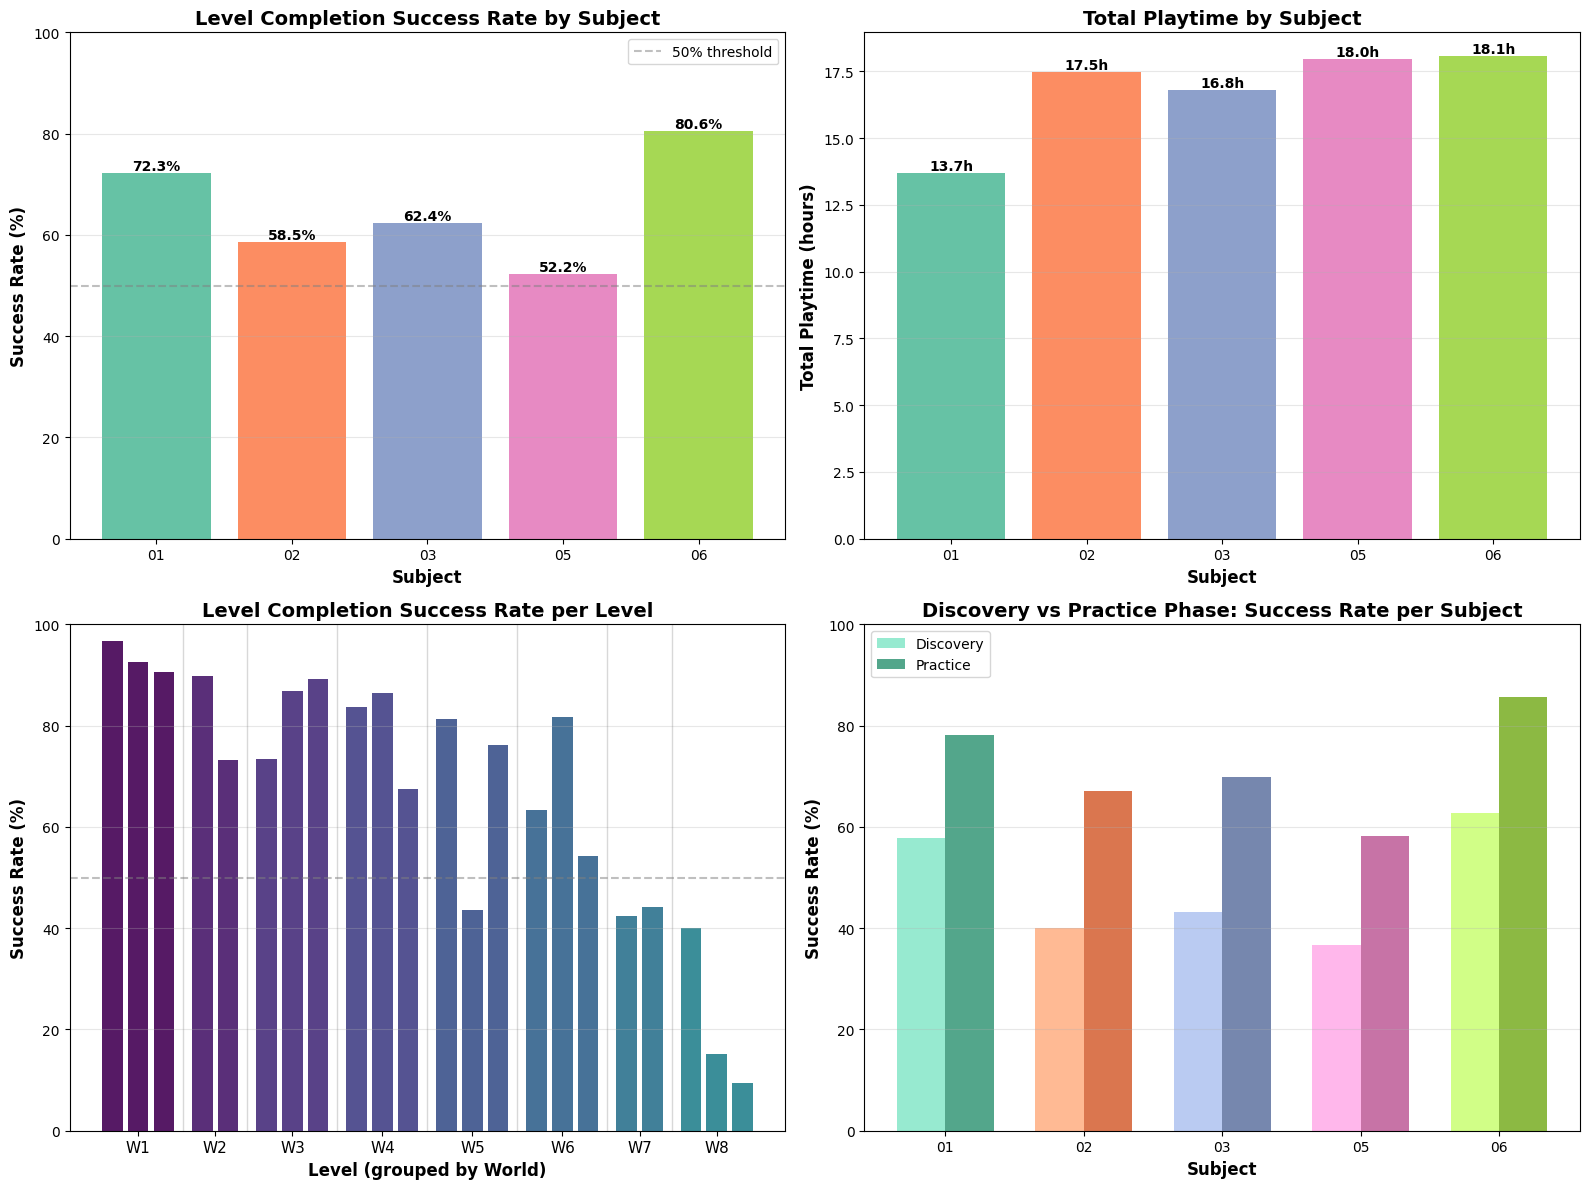


✅ Dataset statistics and visualizations complete!


In [4]:
# Display dataset-wide statistics
from utils import compute_dataset_statistics
from visualization import plot_dataset_statistics
import matplotlib.pyplot as plt

# Print statistics table
compute_dataset_statistics(replay_data, SOURCEDATA_PATH)

# Create visualizations
fig = plot_dataset_statistics(replay_data)
plt.show()

print("\n✅ Dataset statistics and visualizations complete!")

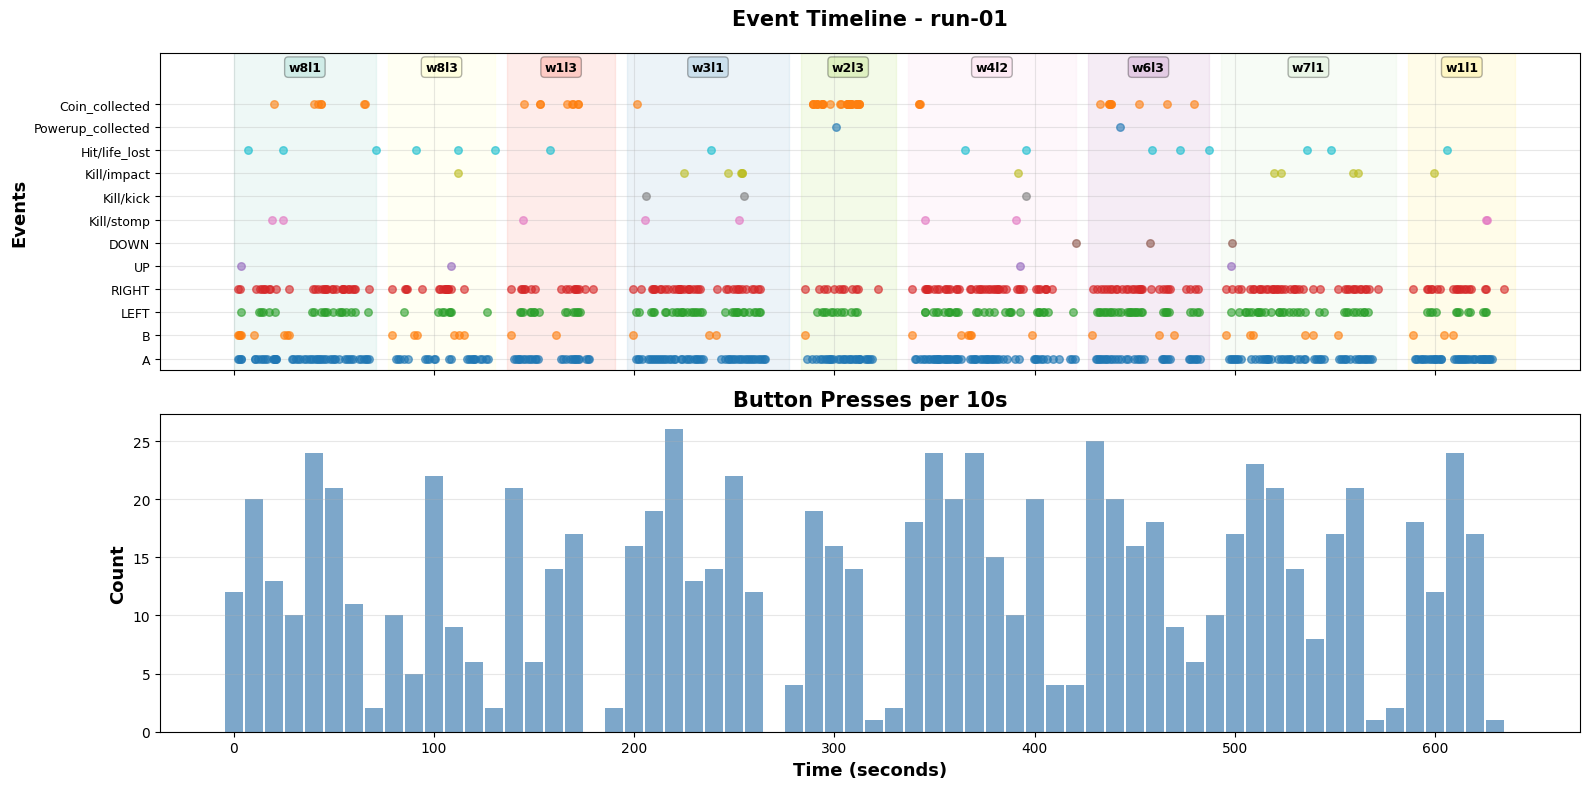

In [5]:
# Event timeline for first run
import matplotlib.pyplot as plt
from visualization import plot_event_timeline



if EVENTS_LOADED and len(all_events) > 0:
    # Filter replays for the first run
    run_number = runs[0]  # e.g., 'run-001'
    run_replays = [r for r in session_replays if r.get('Run', '') == run_number]
    
    fig = plot_event_timeline(all_events[0], runs[0])
    plt.show()
else:
    print("Timeline not available.")

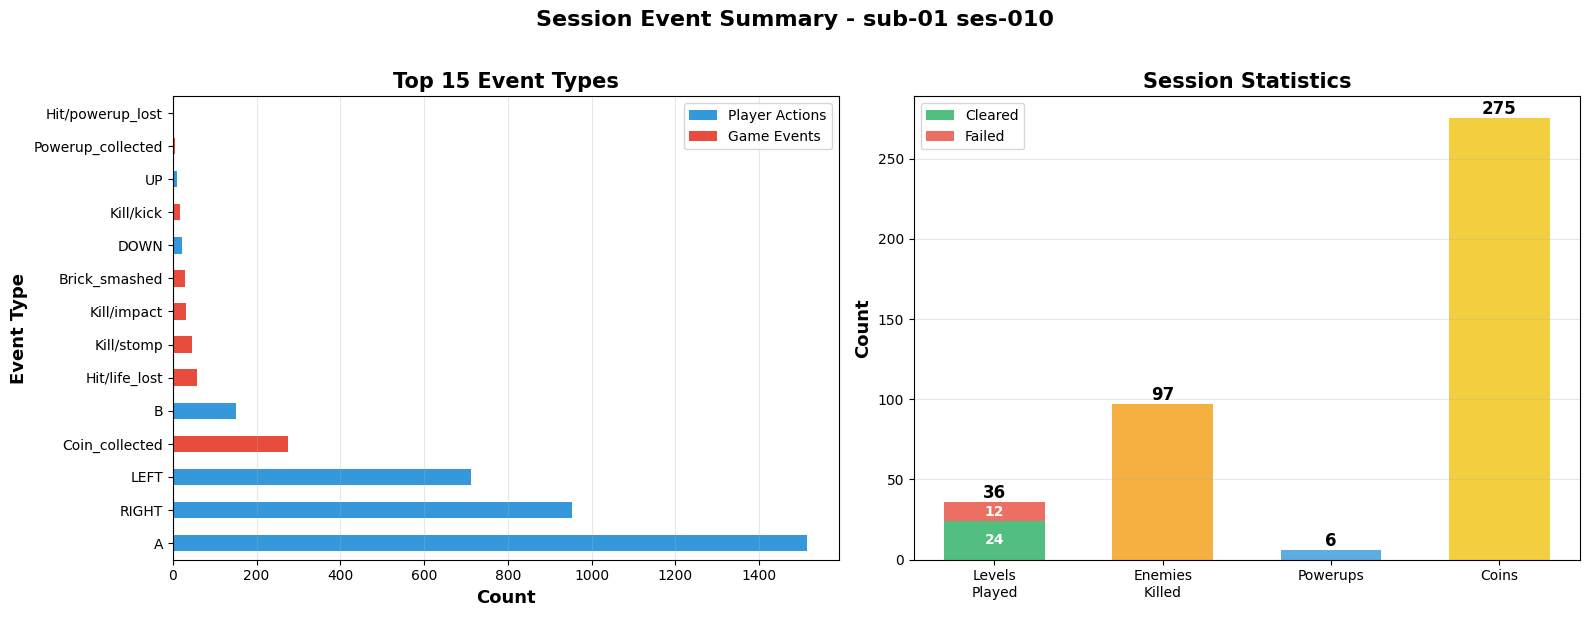

In [6]:
# Visualize event frequencies
import matplotlib.pyplot as plt
from visualization import plot_event_frequencies

fig = plot_event_frequencies(
    session_events, session_replays,
    SUBJECT, SESSION
)
plt.show()

---

## 🚀 Ready for More?

Now that you've explored the dataset structure and behavioral patterns, it's time to dive into the brain data!

### Next Stops on Your Journey:

**📓 Notebook 01: Event-Based GLM Analysis**  
Map button presses to brain activity and test motor control hypotheses. Watch contralateral activations light up as Mario jumps and runs!

**📓 Notebook 02: Reinforcement Learning Agent**  
Train an AI agent to play Mario and extract hierarchical representations from its neural network. Spoiler: it learns way more than just "jump on enemies"!

**📓 Notebook 03: Brain Encoding Models**  
The grand finale! Use the RL agent's representations to predict brain activity. Discover which brain regions encode low-level features vs. high-level game strategies.

---

**Each notebook builds on the previous one, but feel free to jump around if you're curious!**

Happy brain-gaming! 🎮🧠

---